# Viral Data Analysis

Date: 2020.10.25

Author: © 2020 Dovilė Komolovaitė

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

Here we analyze open COVID-19 data from https://ourworldindata.org/ to answer the following questions:

1. [How did the value of 10 Lithuanian stocks change on the first day of quarantine?](#Q1)
1. [Which stocks were most affected during quarantine?](#Q2)
1. [Do the COVID cases help predict future stock values?](#Q3)

We additionally uses data from:
* https://finance.yahoo.com/


This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

## Load the data

Import Libraries

In [106]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate
import math
from itertools import combinations
import time
from datetime import datetime, timedelta

### Load COVID data

Download the data to cache locally. Do this once (a day), and comment out, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [107]:
import requests
fname = 'owid-covid-data.csv'
url = 'https://covid.ourworldindata.org/data/' + fname
r = requests.get(url)
open(fname, 'wb').write(r.content)

11539816

Load the file to Pandas.

In [108]:
path = 'data\\owid-covid-data.csv'
df = pd.read_csv(path, parse_dates=[3], low_memory=False)
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


Check the columns available.

In [109]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index'],
      dtype='object')

The columns are explained [here](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv).

1. Get pandemic data from Lithuania and leave necessary columns

In [110]:
df_lt = df[df.location == 'Lithuania'][['date', 'new_cases', 'new_deaths']]
df_lt['date'] = pd.to_datetime(df_lt['date'])
df_lt.set_index('date', inplace=True)

In [111]:
df_lt.head()

,new_cases,new_deaths
date,,
2019-12-31,0.0,0.0
2020-01-01,0.0,0.0
2020-01-02,0.0,0.0
2020-01-03,0.0,0.0
2020-01-04,0.0,0.0


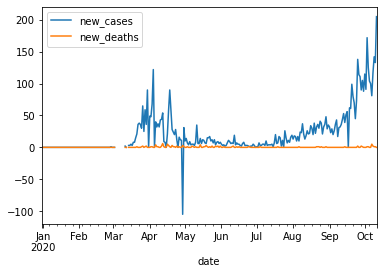

In [112]:
df_lt.plot()
plt.show()

2. From the graph above, we see an outlier because new cases of covid can not be a negative number. So we define that value to be 0.

In [113]:
df_lt[df_lt.new_cases<0]

,new_cases,new_deaths
date,,
2020-04-29,-105.0,3.0


In [114]:
df_lt[df_lt.new_cases<0] = 0

In [115]:
assert df_lt[df_lt.new_cases<0].any().any() == False
assert df_lt[df_lt.new_deaths<0].any().any() == False

3. There is also unregistered data, so all Nan values are changed to 0.

In [116]:
df_lt.fillna(0, inplace=True)

4. Get statistics and plot fixed data.

In [117]:
df_lt.describe()

,new_cases,new_deaths
count,286.000000,286.00000
mean,21.216783,0.34965
std,32.437284,0.84404
min,0.000000,0.00000
25%,0.000000,0.00000
50%,7.000000,0.00000
75%,29.750000,0.00000
max,205.000000,6.00000


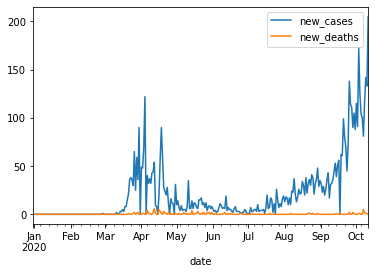

In [118]:
df_lt.plot()
plt.show()

### Load Stocks data

Get 10 Lithuanian stocks data from https://finance.yahoo.com/ and save it in the folder 'lithuanian_stocks'.

In [119]:
folder_path = 'data\\lithuanian_stocks\\'
stock_info_list = os.listdir(folder_path)
print(stock_info_list)

['APG1L.VS.csv', 'GRG1L.VS.csv', 'KNF1L.VS.csv', 'LNA1L.VS.csv', 'PZV1L.VS.csv', 'RSU1L.VS.csv', 'SAB1L.VS.csv', 'VBL1L.VS.csv', 'VLP1L.VS.csv', 'ZMP1L.VS.csv']


In [120]:
stocks_dict = {} # dictionary for stocks

for i, file_name in enumerate(stock_info_list):
    # read one file
    data = pd.read_csv(folder_path+file_name, parse_dates=[0])
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    # store data
    part = file_name.split('.')
    stocks_dict[part[0]] = data

In [121]:
stocks_list = list(stocks_dict.keys())
stocks_list

['APG1L',
 'GRG1L',
 'KNF1L',
 'LNA1L',
 'PZV1L',
 'RSU1L',
 'SAB1L',
 'VBL1L',
 'VLP1L',
 'ZMP1L']

In [122]:
one_stock_df = stocks_dict[stocks_list[0]]
one_stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,1.595,1.595,1.595,1.595,1.373817,0.0
2019-01-02,1.600,1.630,1.600,1.630,1.403964,22770.0
2019-01-03,1.630,1.630,1.620,1.630,1.403964,5905.0
2019-01-04,1.630,1.640,1.625,1.625,1.399657,20798.0
2019-01-07,1.630,1.630,1.620,1.630,1.403964,22869.0


Investigate missing values

In [123]:
one_stock_df[one_stock_df.Close.isnull()]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-20,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-18,NaN,NaN,NaN,NaN,NaN,NaN


Drop missing values

In [124]:
for stock in stocks_list:
    stock_df = stocks_dict[stock]
    stock_df.dropna(inplace=True)

<a id='Q1'></a>
## 1. How did the value of 10 Lithuanian stocks change on the first day of quarantine?

Several date constants denoting events in Lithuania.

In [125]:
quarantine_start = datetime(2020, 3, 16)
quarantine_end = datetime(2020, 6, 17)

first_covid_case = df_lt[df_lt.new_cases>0].index[0]
first_covid_death = df_lt[df_lt.new_deaths>0].index[0]

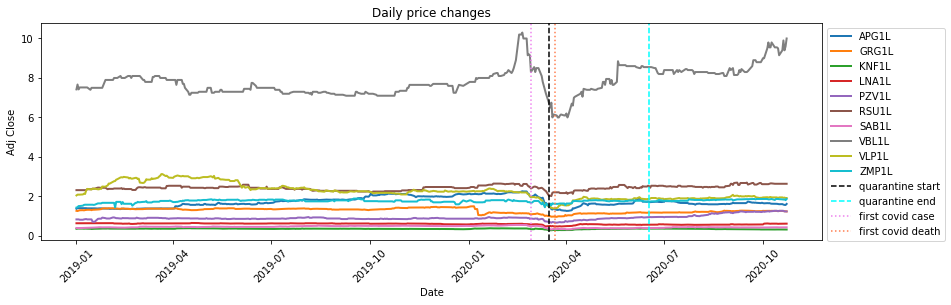

In [126]:
fig, ax = plt.subplots(figsize=(14, 4))

for stock in stocks_list:
    ax.plot(stocks_dict[stock].index, stocks_dict[stock]['Adj Close'], linewidth=2, label=stock)

plt.axvline(x=quarantine_start, color='k', linestyle='--', label = 'quarantine start')
plt.axvline(x=quarantine_end, color='cyan', linestyle='--',label = 'quarantine end')
plt.axvline(x=first_covid_case, color='violet', linestyle='dotted',label = 'first covid case')
plt.axvline(x=first_covid_death, color='coral', linestyle='dotted',label = 'first covid death')

ax.set(xlabel='Date', ylabel='Adj Close', title='Daily price changes')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Calculate daily return value

In [127]:
for stock in stocks_list:
    stock_df = stocks_dict[stock]
    stock_df['daily_return'] = stock_df['Adj Close'].pct_change()  # Percentage change between the current and a prior element
    stock_df.dropna(inplace=True)

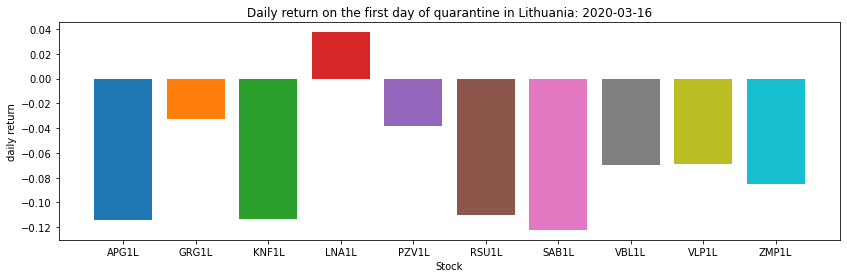

In [128]:
fig, ax = plt.subplots(figsize=(14, 4))

for stock in stocks_list:
    stock_df = stocks_dict[stock]
    ax.bar(stock, stock_df.loc[quarantine_start, 'daily_return'], linewidth=2, label=stock)

ax.set(xlabel='Stock', ylabel='daily return', 
       title=f'Daily return on the first day of quarantine in Lithuania: {quarantine_start.date()}')
plt.show()

The prices of each stock analyzed fell on the day of quarantine. The greatest losses on quarantine day felt: AB Siauliu Bankas (SAB1L.VS), Rokiskio Suris AB (RSU1L.VS), APB Apranga (APG1L.VS), AB Klaipedos nafta (KNF1L.VS)

<a id='Q2'></a>
## 2. Which stocks were most affected during quarantine?

Because the market started to react to COVID19 even before the quarantine. This start date, which indicates "normal" market behavior, will be one month before the official quarantine.

Calculate Volatility (standart deviation of returns) for periods: 1week/1month. Then plot the average volatility value during the quarantine period in Lithuania.

In [129]:
month_before_quarantine = quarantine_start - timedelta(days=28)

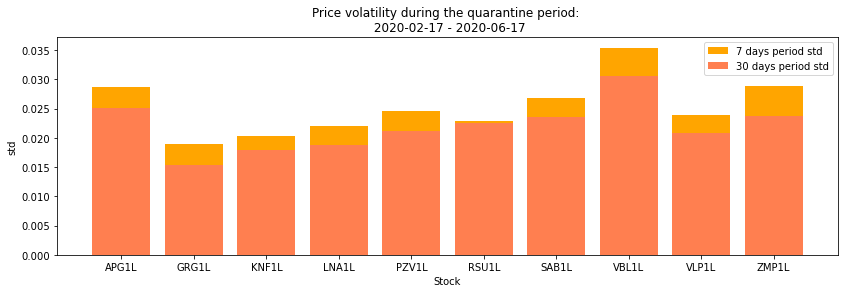

In [130]:
fig, ax = plt.subplots(figsize=(14, 4))

for stock in stocks_list:
    stock_df = stocks_dict[stock]
    stock_df['std7'] = stock_df['Adj Close'].pct_change().rolling(7).std()
    stock_df['std30'] = stock_df['Adj Close'].pct_change().rolling(30).std()
    price_diff7 = stock_df.loc[month_before_quarantine:quarantine_end, 'std7'].mean()
    price_diff30 = stock_df.loc[month_before_quarantine:quarantine_end, 'std30'].mean()
    ax.bar(stock, price_diff30, linewidth=2, color = 'orange')
    ax.bar(stock, price_diff7, linewidth=2, color = 'coral')

ax.set(xlabel='Stock', ylabel='std', 
       title=f'Price volatility during the quarantine period: \n {month_before_quarantine.date()} - {quarantine_end.date()}')

legend_elements = [ax.bar(stock, price_diff30, linewidth=2, color = 'orange'),
                   ax.bar(stock, price_diff7, linewidth=2, color = 'coral')]
plt.legend(legend_elements, ['7 days period std', '30 days period std'], bbox_to_anchor=(1, 1))
plt.show()

Higher volatility indicates that the market is fluctuating a lot and is considered a riskier investment.

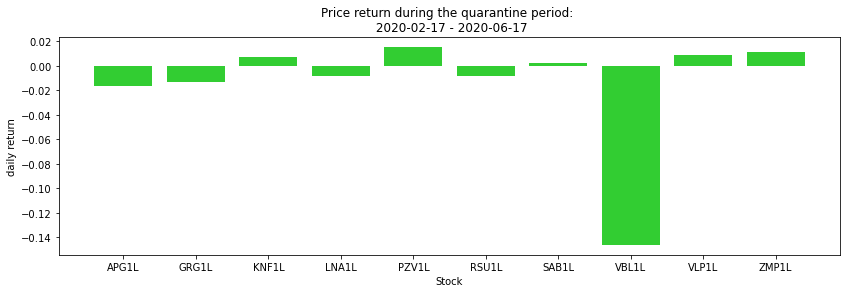

In [131]:
fig, ax = plt.subplots(figsize=(14, 4))

for stock in stocks_list:
    stock_df = stocks_dict[stock]
    stock_df['return'] = stock_df['Adj Close'].pct_change()
    price_diff = stock_df.loc[quarantine_end, 'return'] - stock_df.loc[month_before_quarantine, 'return']
    ax.bar(stock, price_diff, linewidth=2, color = 'limegreen')

ax.set(xlabel='Stock', ylabel='daily return', 
       title=f'Price return during the quarantine period: \n {month_before_quarantine.date()} - {quarantine_end.date()}')

plt.show()

From both plots we can notice that "Vilkyškių pieninė" (VBL1L) experienced the highest volatility and price loss during the quarantine period. But if we look at the daily prices, we will see that "Vilkyškių pieninė" was fast enough to return to normal growth.

<a id='Q3'></a>
## 3. Do the COVID cases help predict future stock values?

Merge stock data with covid data

In [132]:
def merge_dataframes(stocks_dict, df_lt):
    merged_dict = {} 

    for stock in stocks_list:
        stock_df = stocks_dict[stock]
        merged_df = pd.merge(stock_df, df_lt, how='left', left_index=True, right_index=True)
        merged_df.fillna(0, inplace=True)    
        merged_dict[stock] = merged_df
    
    return merged_dict

**Create features**

We try to predict column 'Adj Close' values having these window statistics of 1 week and 1 month:

1) Moving average

2) Exponentially weighted mean

3) Z-score: z = (x-μ)/σ

4) Covid cases mean


In [154]:
basic_features = ['weekly_mavg', 'monthly_mavg', 'monthly_z_score',
                      'weekly_exp_mean', 'monthly_exp_mean', 
                      'weekly_cases_mavg', 'monthly_cases_mavg']

def create_features(merged_dict, column_to_predict, basic_features):
    feature_dict = {}
    
    for stock in stocks_list:
        feature_df = merged_dict[stock]
        feature_df['weekly_mavg'] = feature_df['Adj Close'].rolling(7).mean()
        feature_df['monthly_mavg'] = feature_df['Adj Close'].rolling(30).mean()
        feature_df['weekly_exp_mean'] = feature_df['Adj Close'].ewm(7).mean()
        feature_df['monthly_exp_mean'] = feature_df['Adj Close'].ewm(30).mean()
        feature_df['monthly_z_score'] = (feature_df['Adj Close'] - feature_df['Adj Close'].rolling(30).mean())\
                                                / feature_df['Adj Close'].rolling(30).std()
        feature_df['weekly_cases_mavg'] = feature_df['new_cases'].rolling(7).mean()
        feature_df['monthly_cases_mavg'] = feature_df['new_cases'].rolling(30).mean()

        feature_df = feature_df[basic_features + column_to_predict].copy()
        feature_df.dropna(inplace=True)

        assert pd.isna(feature_df).any().any() == False
        assert np.isfinite(feature_df).any().any() == True

        feature_dict[stock] = feature_df
    
    return feature_dict

**Train Validation Test split** 

In [155]:
def split_data(df, stock_name, test_size=0.1, valid_size=0.1, plot=True):
    """
    Split data using Out-of-time sampling technique (includes a time dimension)
    """
    test_idx  = int(df.shape[0] * (1-test_size))
    valid_idx = int(df.shape[0] * (1-(valid_size+test_size)))
    
    train_df = df.iloc[:valid_idx].copy()
    valid_df = df.iloc[valid_idx:test_idx].copy()
    test_df  = df.iloc[test_idx:].copy()
    
    if plot:
        fig, ax = plt.subplots(figsize=(14, 4))
        ax.plot(train_df.index, train_df['Adj Close'], linewidth=2, label='train')
        ax.plot(valid_df.index, valid_df['Adj Close'], linewidth=2, label='valid')
        ax.plot(test_df.index, test_df['Adj Close'], linewidth=2, label='test')
        ax.set(xlabel='Date', ylabel='Adj Close', 
               title=f'Splitted {stock_name} stock data')
        plt.legend()
        plt.show()
    
    return train_df, valid_df, test_df

**Pipeline**

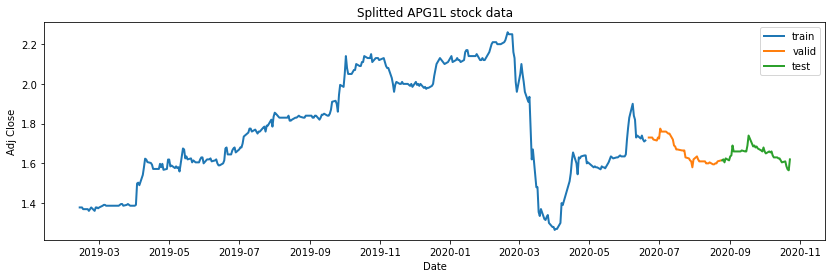

In [156]:
# column to forecast:
column_to_predict = ['Adj Close']

merged_dict = merge_dataframes(stocks_dict, df_lt)

feature_dict = create_features(merged_dict, column_to_predict, basic_features)

# predict only one stock data (for now):
stock_name = stocks_list[0]
df = feature_dict[stock_name]
train_df, valid_df, test_df = split_data(df, stock_name = stock_name,
                                         test_size=0.1, 
                                         valid_size=0.1, 
                                         plot=True)

In [158]:
def separate_X_y(df, column_to_predict):
    # split features and predicted value
    y = df[column_to_predict[0]].copy()
    X = df.drop([column_to_predict[0]], 1)
    return X, y

In [159]:
X_train, y_train = separate_X_y(train_df, column_to_predict)
X_valid, y_valid = separate_X_y(valid_df, column_to_predict)
X_test, y_test = separate_X_y(test_df, column_to_predict)

**Create and train model**

In [160]:
def train_model(X_train, y_train):
    model = LinearRegression()  # LinearRegression Object
    model.fit(X_train, y_train)  # fit training data to the model
    return model

def evaluate_model(model, X_valid, y_valid):
    # Get confidence score - R^2 coefficient
    return model.score(X_valid, y_valid)

def predict_values(model, X_valid, y_valid, X_train, y_train, stock_name=None, plot=True, 
                   include_test_data=False, X_test=None, y_test=None):
    forecast_set = model.predict(X_valid) # set that will contain the forecasted data
    if include_test_data:
        forecast_set_test = model.predict(X_test)
    
    if plot:
        plt.figure(figsize=(14, 4))
        plt.plot(y_train, color='blue', label='Training Data')
        plt.plot(y_valid.index, y_valid, color='red', label='Actual Price')
        plt.plot(y_valid.index, forecast_set, color='green', linestyle='dashed', label='Predicted Price')
        if include_test_data:
            plt.plot(y_test.index, y_test, color='orange', label='Actual Test Price')
            plt.plot(y_test.index, forecast_set_test, color='cyan', linestyle='dashed', label='Predicted Test Price')
        plt.title(f'{stock_name} Prices Prediction')
        plt.xlabel('Date')
        plt.ylabel('Adj Close')
        plt.legend(bbox_to_anchor=(1, 1))
        plt.show()
    
    return forecast_set

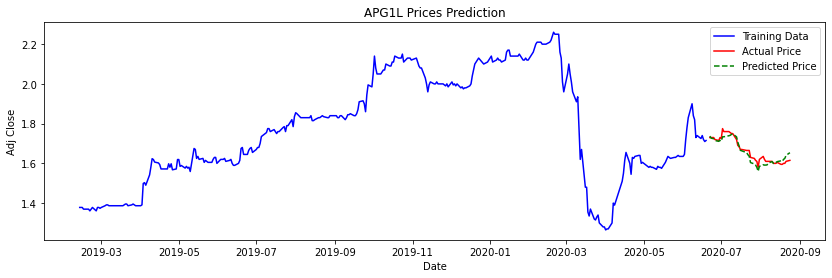

Confidence score: 0.8876810959605865


In [161]:
model = train_model(X_train, y_train)
confidence_score = evaluate_model(model, X_valid, y_valid)
forecast_set = predict_values(model, X_valid, y_valid, X_train, y_train, stock_name=stock_name, plot=True)
print(f'Confidence score: {confidence_score}')

**Get the most optimal feature list**

In [162]:
def select_best_features(merged_dict, stock_name, basic_features, column_to_predict):
    confidence_score_dict = {}
    
    combinations_list = sum([list(map(list, combinations(basic_features, i))) 
                             for i in range(len(basic_features) + 1)], [])[1:]
    
    # loop for every possible feature combination:
    for features in combinations_list:
        feature_dict = create_features(merged_dict, column_to_predict, features)
        df = feature_dict[stock_name]
        train_df, valid_df, test_df = split_data(df, stock_name = stock_name,
                                             test_size=0.1,valid_size=0.1, plot=False)
        X_train, y_train = separate_X_y(train_df, column_to_predict)
        X_valid, y_valid = separate_X_y(valid_df, column_to_predict)
        X_test, y_test = separate_X_y(test_df, column_to_predict)
        # Create a model
        model = train_model(X_train, y_train)
        confidence_score = evaluate_model(model, X_valid, y_valid)
        confidence_score_dict[str(features)] = confidence_score
    return confidence_score_dict

In [163]:
start_time = time.time()

confidence_score_dict = select_best_features(merged_dict, stock_name, basic_features, column_to_predict)

print(f'Execution time: {round(time.time()-start_time, 2)} sec.')
print('--------------------------------------------------------------------')
print(f'The best confidence score: {round(max(confidence_score_dict.values()), 2)}')
print(f'The best features: {max(confidence_score_dict, key=confidence_score_dict.get)}')

Execution time: 6.88 sec.
--------------------------------------------------------------------
The best confidence score: 0.9
The best features: ['weekly_mavg', 'monthly_mavg', 'monthly_exp_mean', 'monthly_cases_mavg']


That doesn’t make a clear distinction, that it definitely helps predict stock prices, we need to see the relationship with other stocks as well.

**Predict with the most influencial features**

In [164]:
def linear_regression_pipeline(merged_dict, stock_name, basic_features, column_to_predict):
    start_time = time.time()
    # get optimal features
    confidence_score_dict = select_best_features(merged_dict, stock_name, basic_features, column_to_predict)
    optimal_features = max(confidence_score_dict, key=confidence_score_dict.get).strip('"')
    optimal_features = optimal_features.replace("[", "").replace("]", "").replace("'", "").replace(" ", "").split(",")
    
    # predict with optimal features
    feature_dict = create_features(merged_dict, column_to_predict, optimal_features)
    df = feature_dict[stock_name]
    train_df, valid_df, test_df = split_data(df, stock_name = stock_name, test_size=0.1, valid_size=0.1, plot=False)
    
    X_train, y_train = separate_X_y(train_df, column_to_predict)
    X_valid, y_valid = separate_X_y(valid_df, column_to_predict)
    X_test, y_test = separate_X_y(test_df, column_to_predict)
    
    model = train_model(X_train, y_train)
    # valid data
    confidence_score = evaluate_model(model, X_valid, y_valid)
    # test data
    confidence_score_test = evaluate_model(model, X_test, y_test)
    # predict:
    forecast_set_test = predict_values(model, X_valid, y_valid, X_train, y_train, stock_name=stock_name, plot=True,
                                      include_test_data=True, X_test=X_test, y_test=y_test)

    print(f'Execution time: {round(time.time()-start_time, 2)} sec.')
    print('--------------------------------------------------------------------')
    print(f'The best features: {optimal_features}')
    print(f'The best confidence score for validation data: {round(confidence_score, 2)}')
    print(f'Confidence score for test data: {round(confidence_score_test, 2)}')
    

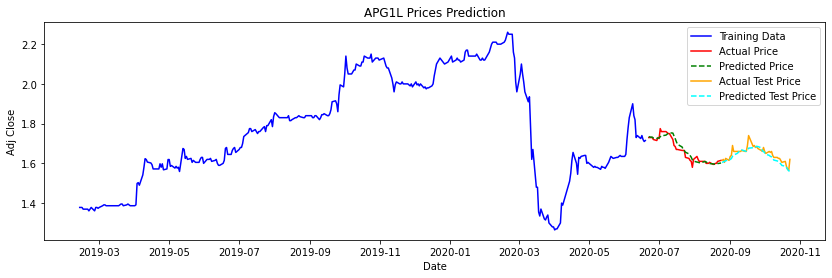

Execution time: 6.9 sec.
--------------------------------------------------------------------
The best features: ['weekly_mavg', 'monthly_mavg', 'monthly_exp_mean', 'monthly_cases_mavg']
The best confidence score for validation data: 0.9
Confidence score for test data: 0.66


In [165]:
linear_regression_pipeline(merged_dict, stock_name, basic_features, column_to_predict)

**Additionally check what optimal features to choose for other stocks and what their predictions are**

This will take a little longer

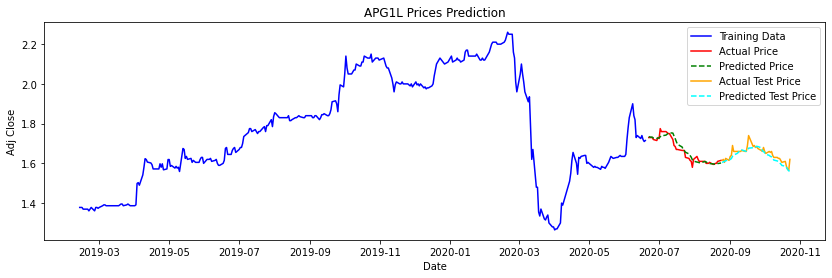

Execution time: 6.88 sec.
--------------------------------------------------------------------
The best features: ['weekly_mavg', 'monthly_mavg', 'monthly_exp_mean', 'monthly_cases_mavg']
The best confidence score for validation data: 0.9
Confidence score for test data: 0.66


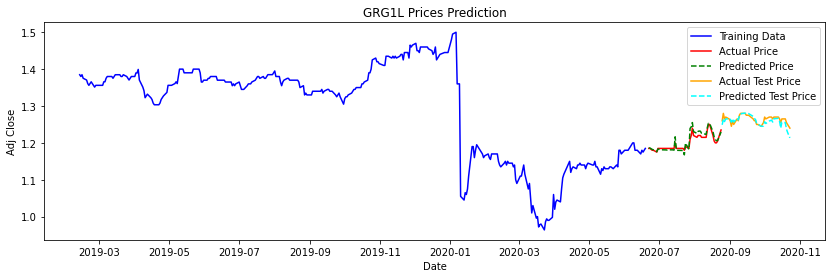

Execution time: 6.98 sec.
--------------------------------------------------------------------
The best features: ['weekly_mavg', 'monthly_mavg', 'monthly_z_score', 'weekly_exp_mean', 'monthly_exp_mean']
The best confidence score for validation data: 0.8
Confidence score for test data: 0.13


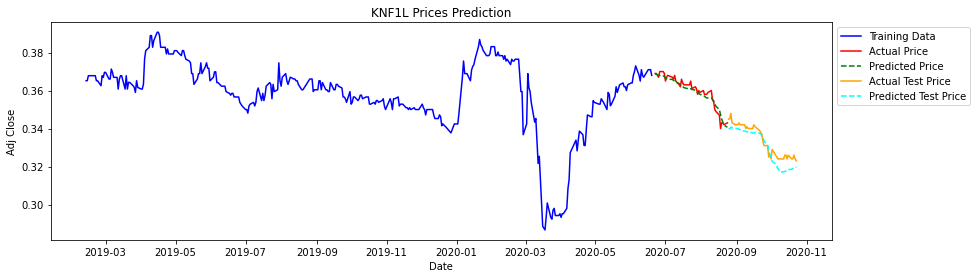

Execution time: 6.83 sec.
--------------------------------------------------------------------
The best features: ['weekly_mavg', 'monthly_mavg', 'weekly_exp_mean', 'monthly_cases_mavg']
The best confidence score for validation data: 0.93
Confidence score for test data: 0.71


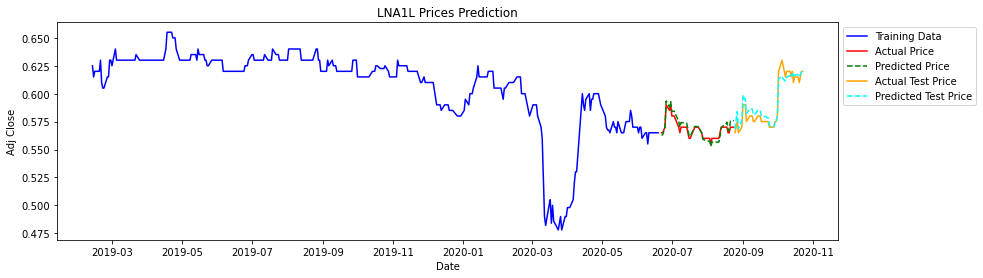

Execution time: 6.99 sec.
--------------------------------------------------------------------
The best features: ['monthly_z_score', 'weekly_exp_mean']
The best confidence score for validation data: 0.85
Confidence score for test data: 0.93


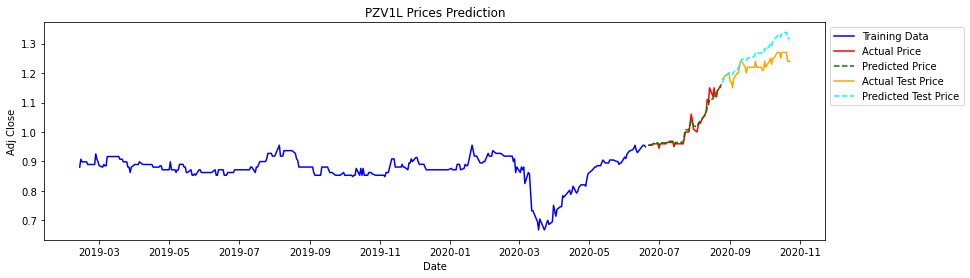

Execution time: 7.53 sec.
--------------------------------------------------------------------
The best features: ['monthly_mavg', 'monthly_z_score', 'weekly_exp_mean', 'monthly_exp_mean', 'monthly_cases_mavg']
The best confidence score for validation data: 0.98
Confidence score for test data: -1.39


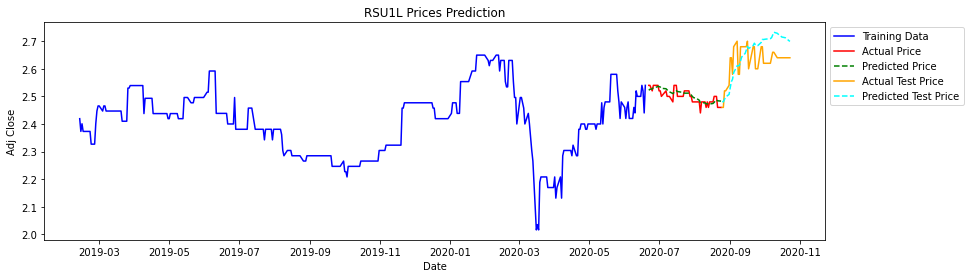

Execution time: 7.33 sec.
--------------------------------------------------------------------
The best features: ['weekly_exp_mean', 'monthly_exp_mean', 'monthly_cases_mavg']
The best confidence score for validation data: 0.62
Confidence score for test data: -0.34


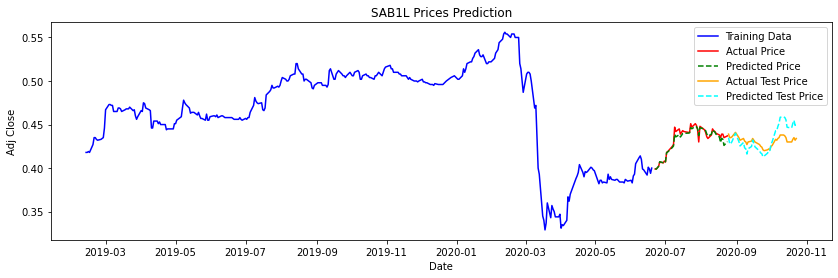

Execution time: 7.39 sec.
--------------------------------------------------------------------
The best features: ['monthly_z_score', 'weekly_exp_mean', 'monthly_cases_mavg']
The best confidence score for validation data: 0.94
Confidence score for test data: -3.42


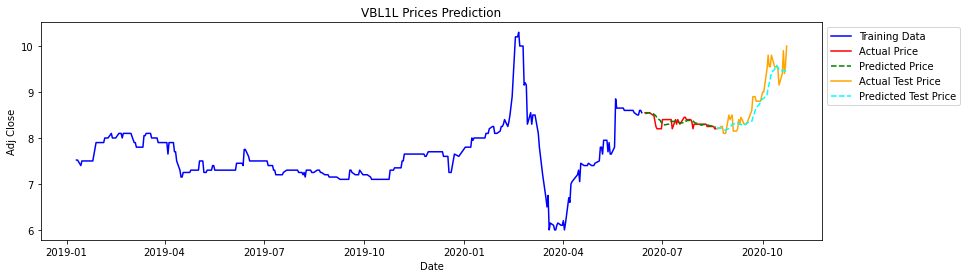

Execution time: 7.52 sec.
--------------------------------------------------------------------
The best features: ['weekly_mavg']
The best confidence score for validation data: 0.44
Confidence score for test data: 0.84


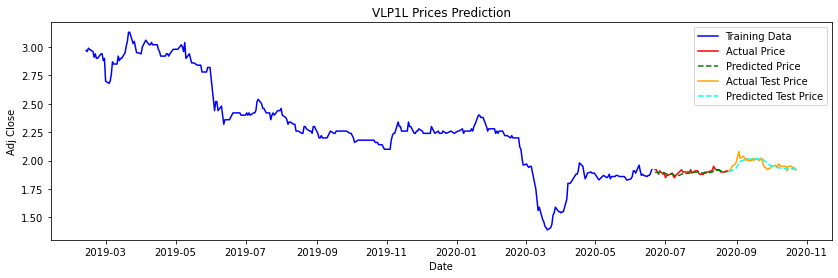

Execution time: 7.33 sec.
--------------------------------------------------------------------
The best features: ['monthly_mavg', 'weekly_exp_mean', 'monthly_exp_mean']
The best confidence score for validation data: 0.3
Confidence score for test data: 0.45


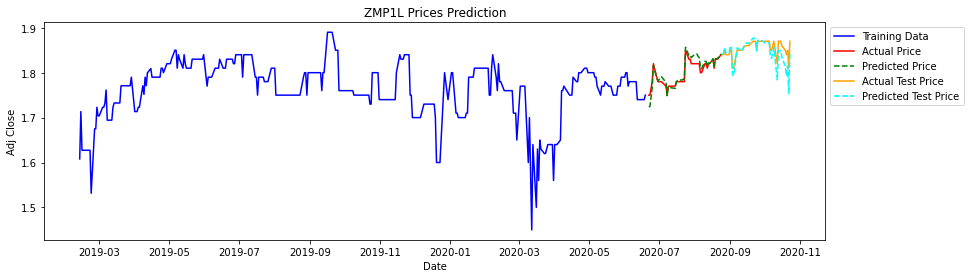

Execution time: 7.27 sec.
--------------------------------------------------------------------
The best features: ['weekly_mavg', 'monthly_z_score', 'monthly_cases_mavg']
The best confidence score for validation data: 0.86
Confidence score for test data: -0.15
--------------------------------------------------------------------
Total execution time: 1.2 min.
--------------------------------------------------------------------


In [166]:
start_time = time.time()

for stock in stocks_list:
    linear_regression_pipeline(merged_dict, stock, basic_features, column_to_predict)

print('--------------------------------------------------------------------')
print(f'Total execution time: {round((time.time()-start_time)/60, 2)} min.')
print('--------------------------------------------------------------------')

**Conclusions**

Since the model has been optimized using a validation dataset, it can achieve high accuracy for that part. The testing dataset predictions remain still quite close to the actual values. For investment purposes, I would recommend experimenting with different accuracy metrics to predict whether the price will rise or fall (excluding size).

From this experiment, we see that 6 out of 10 times the number of Covid cases in Lithuania helps to predict future price values.